In [10]:
import numpy as np
import torch
import pyro
import pyro.distributions as dist
import cairo
import string
import matplotlib.pylab as plt
from pylab import rcParams
rcParams['figure.figsize'] = 0.7,0.7

In [93]:
def render_letter(letter='A',size=14,font='Arial'):
    w = h = size#min(int(size-size*0.2),size-3) # found by trial & error
    surf = cairo.ImageSurface(cairo.FORMAT_RGB24, w, h)
    cr = cairo.Context(surf)

    #draw a background rectangle:
    cr.rectangle(0,0,w,h+5)
    cr.set_source_rgb(1, 1, 1)
    cr.fill()

    cr.select_font_face(font, cairo.FONT_SLANT_NORMAL, cairo.FONT_WEIGHT_NORMAL)
    cr.set_source_rgb(1, 0, 0)
    cr.set_font_size(size) # heigh_pixels = font_size - 4
    cr.move_to(w/6,h-h/6)
    cr.show_text(letter)

    buf = surf.get_data()
    data = np.ndarray(shape=(w, h),
                         dtype=np.uint32,
                         buffer=buf)

    data -= data.min()
    data = data/data.max()

    return data

/home/folzd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


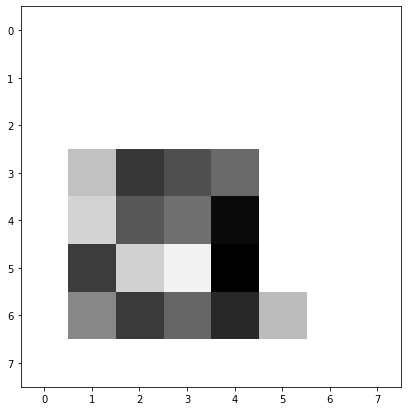

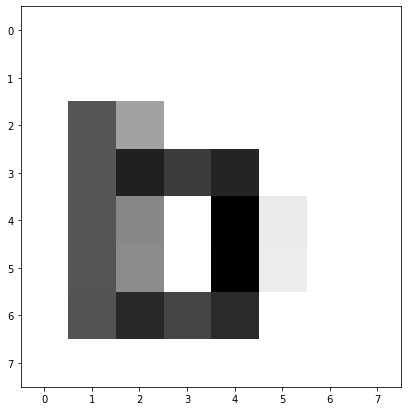

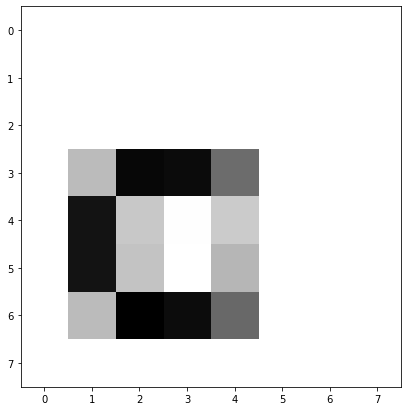

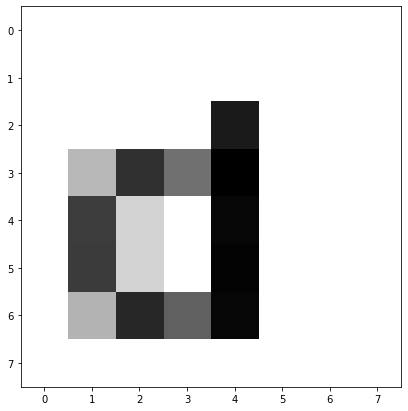

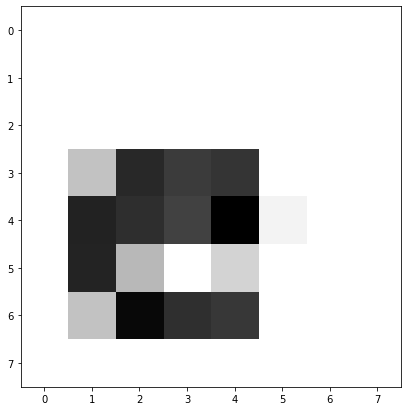

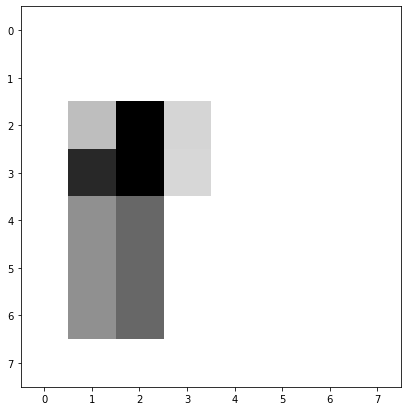

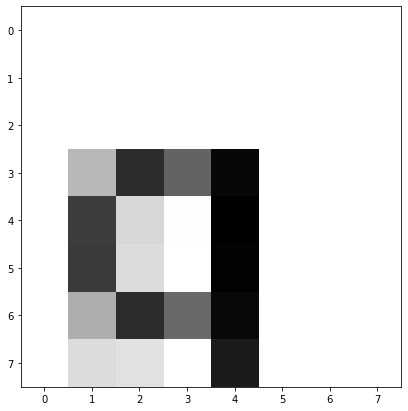

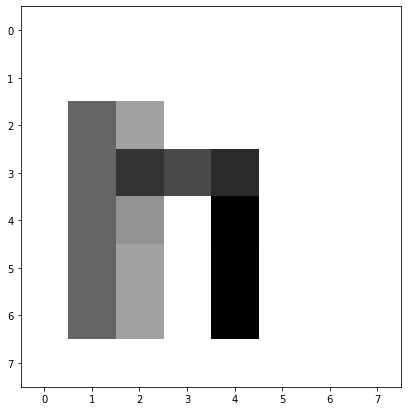

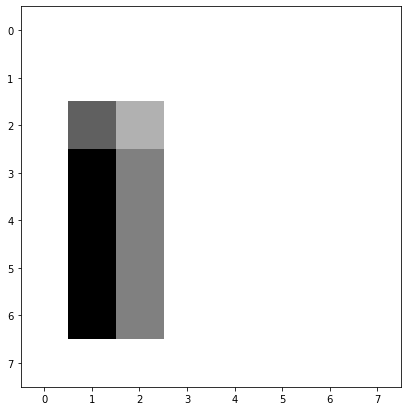

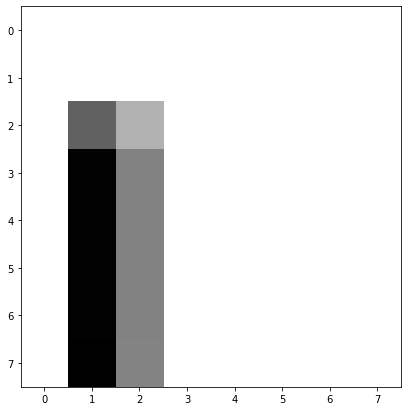

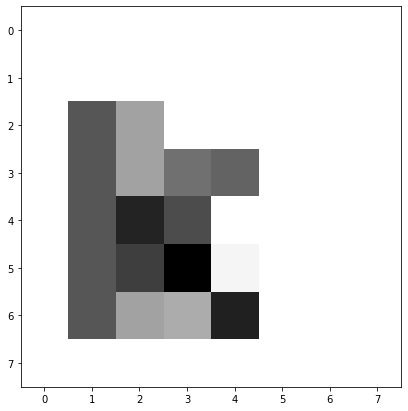

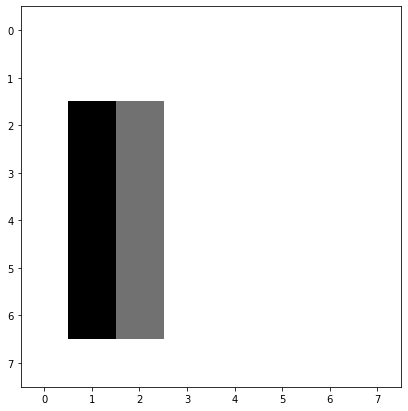

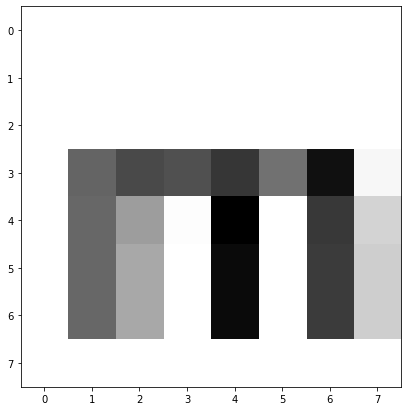

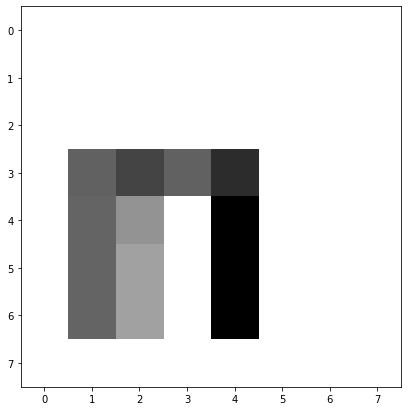

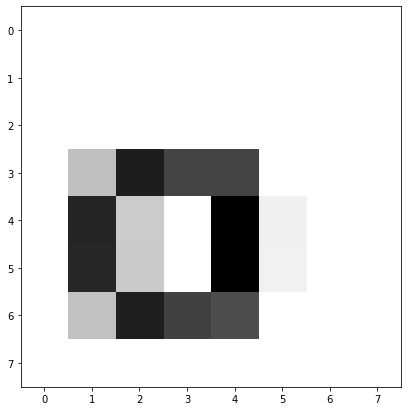

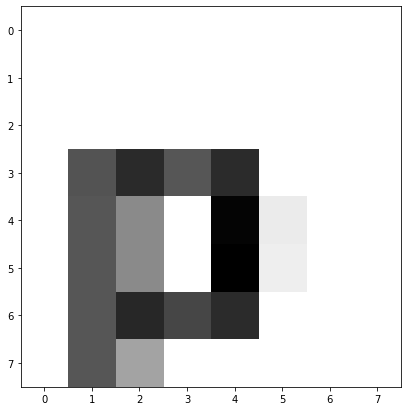

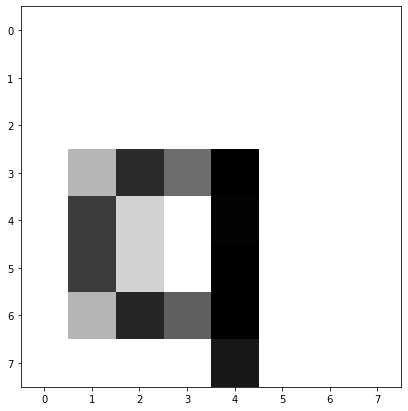

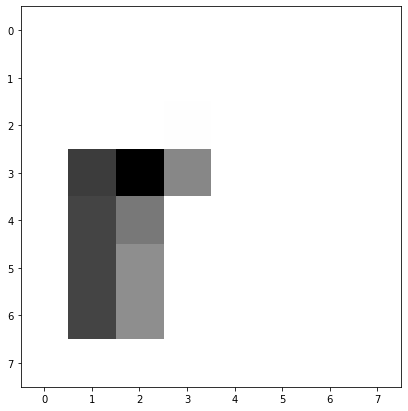

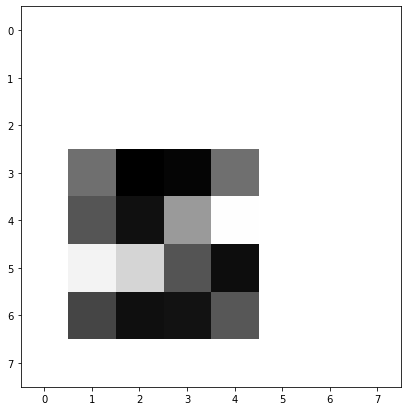

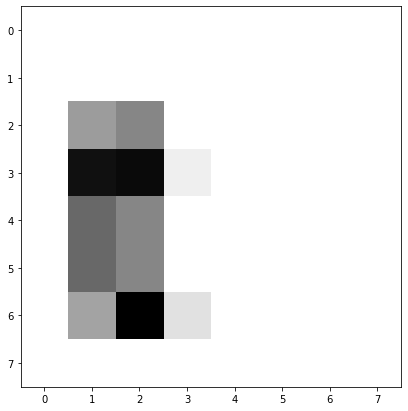

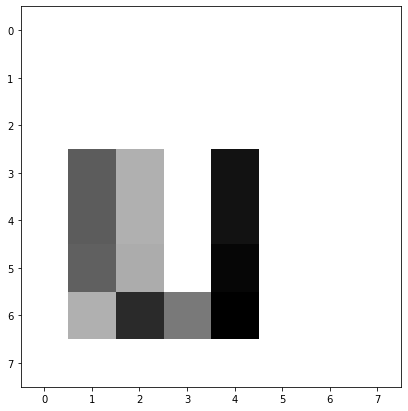

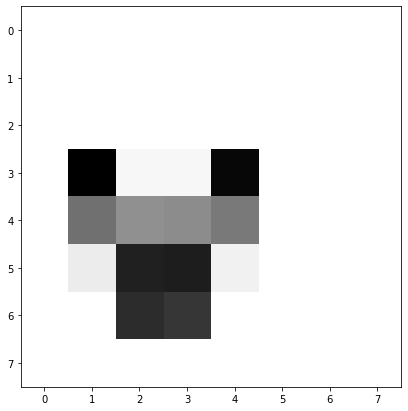

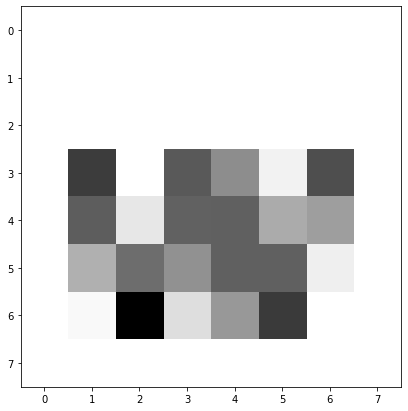

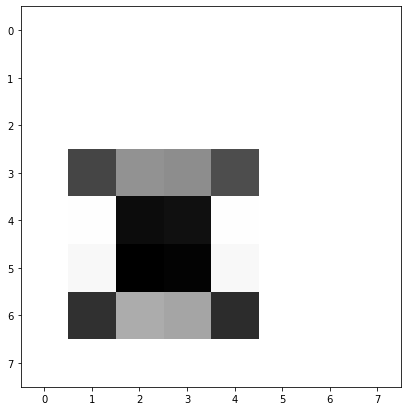

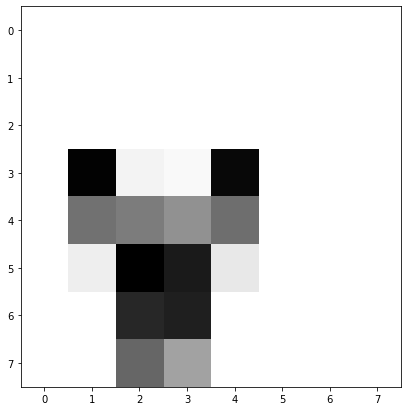

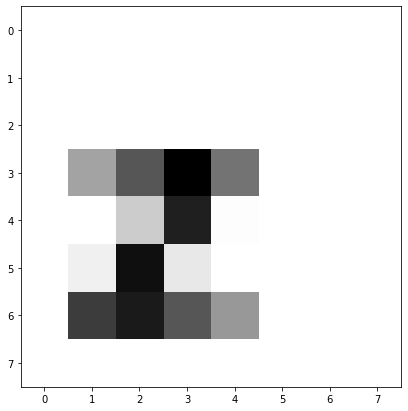

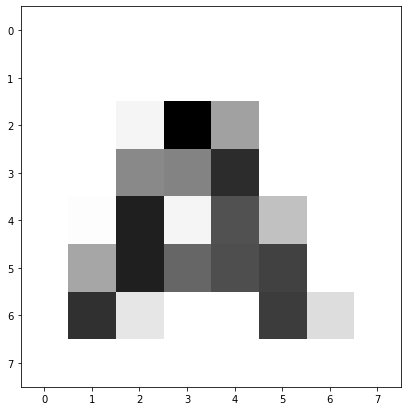

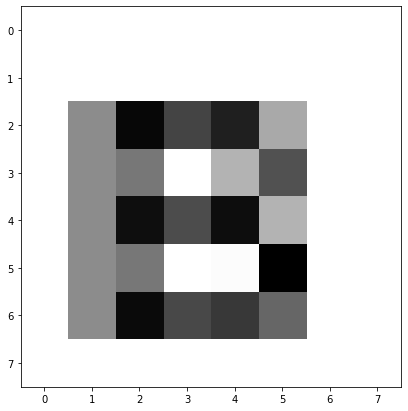

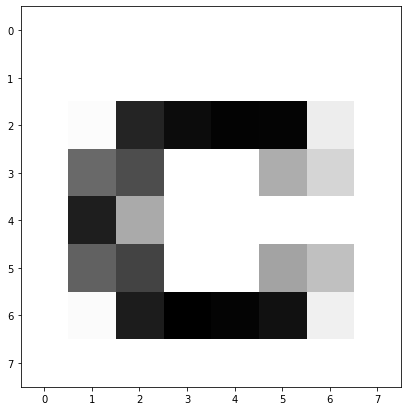

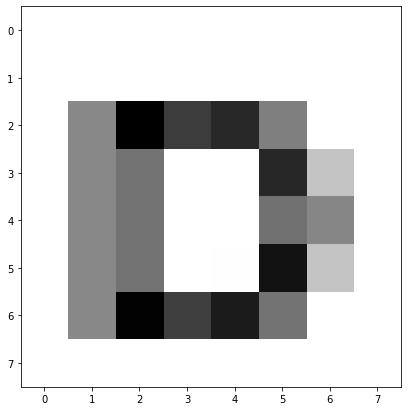

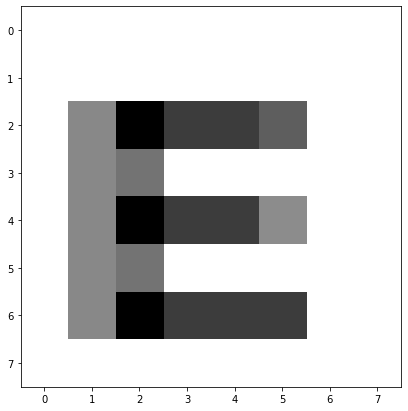

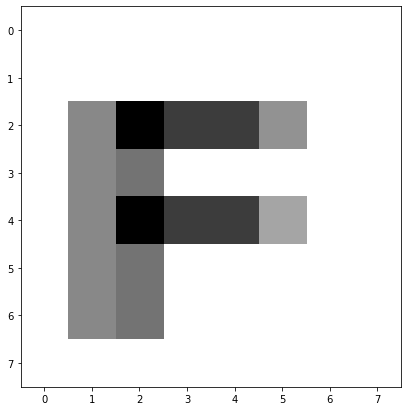

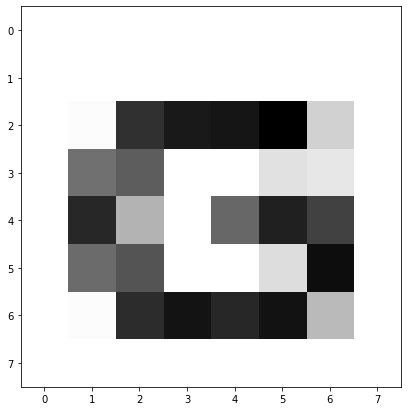

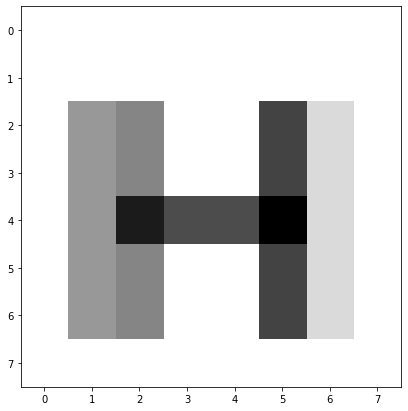

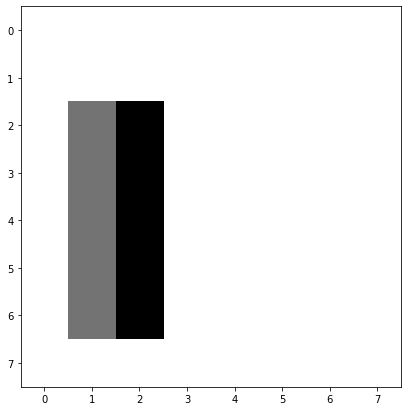

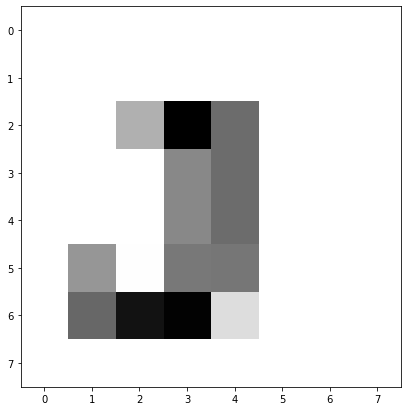

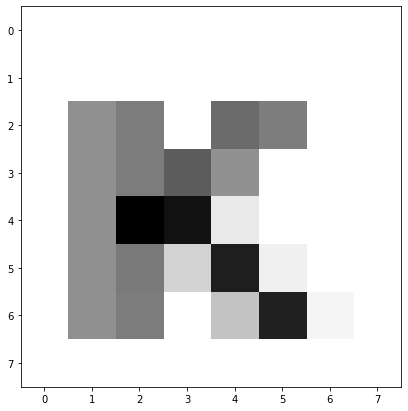

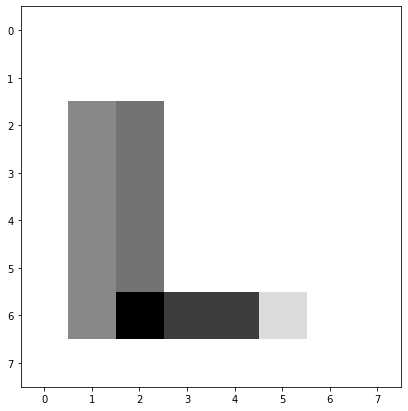

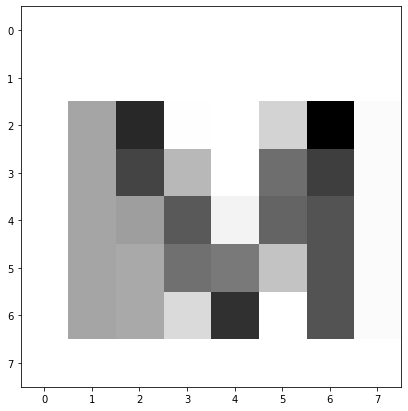

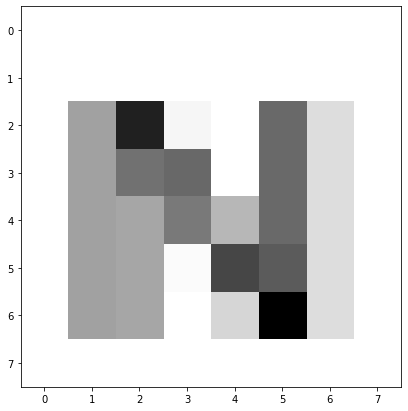

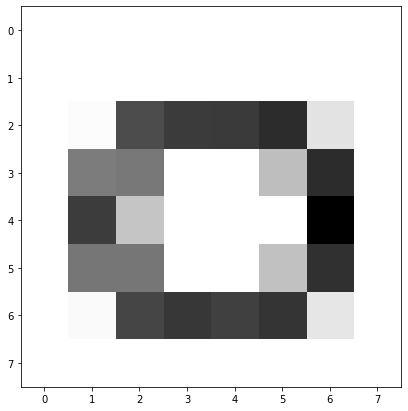

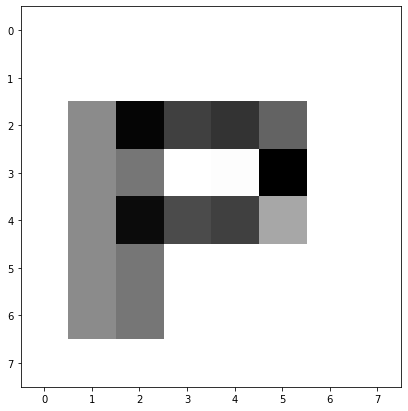

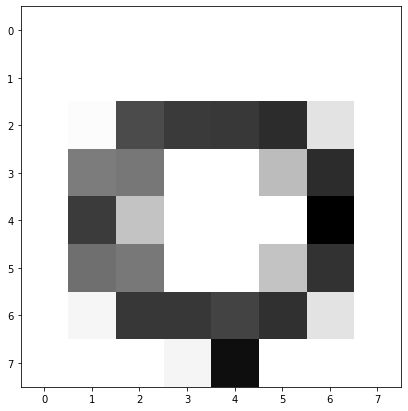

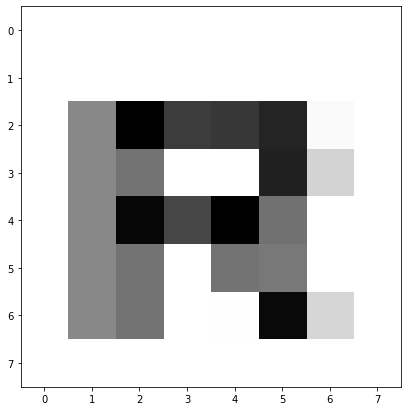

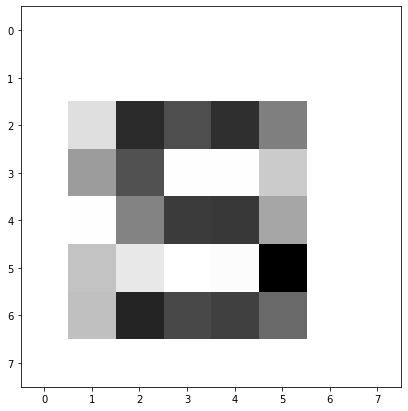

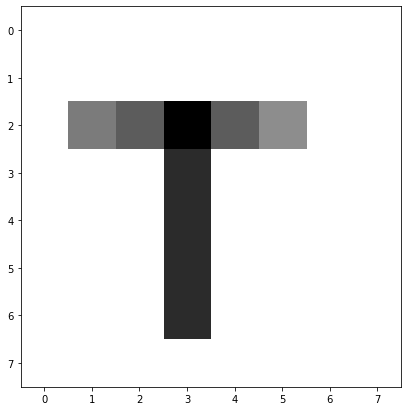

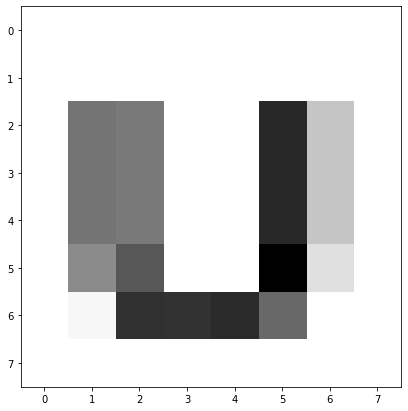

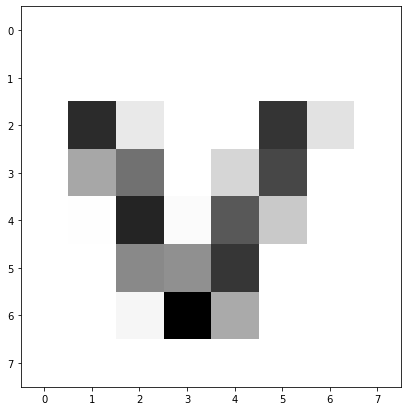

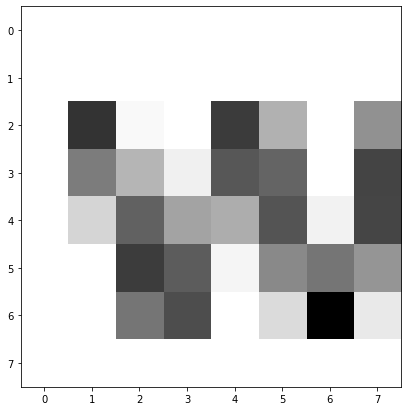

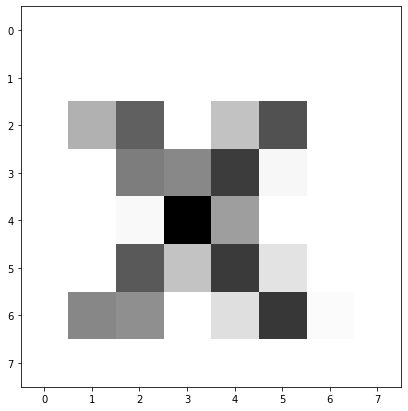

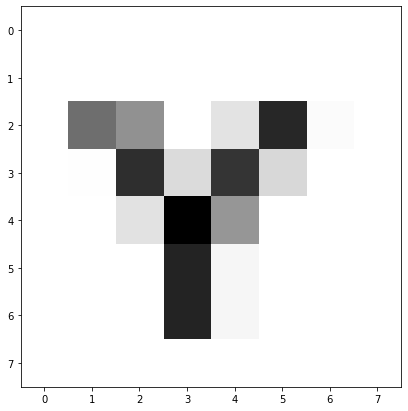

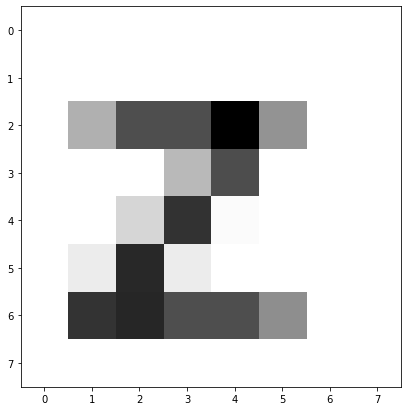

In [94]:
#for letter in string.ascii_letters:
#    plt.figure()
#    plt.imshow(render_letter(letter,8),cmap='gray')

/home/folzd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


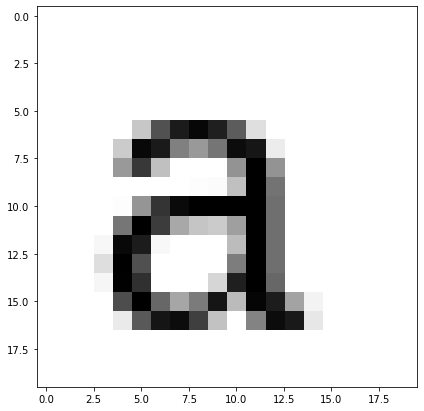

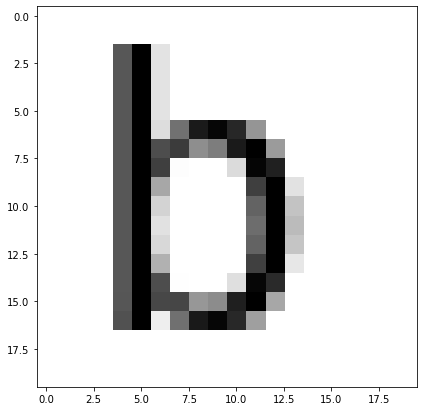

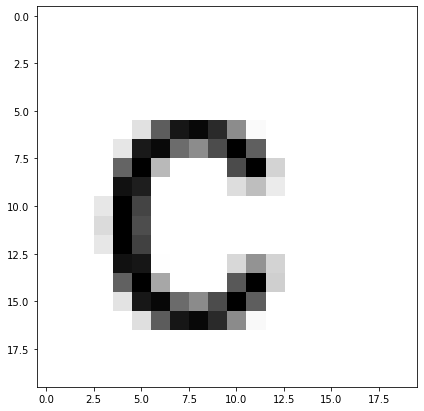

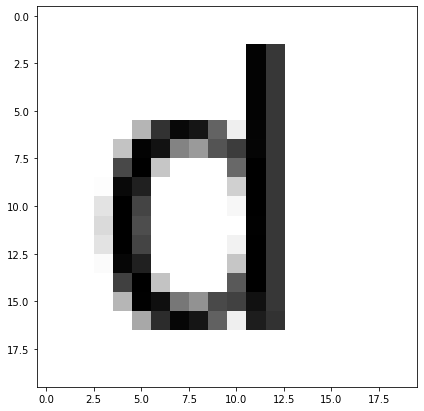

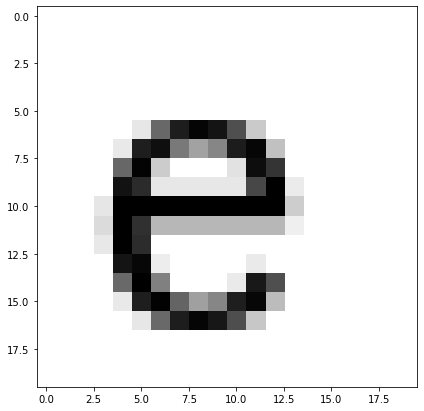

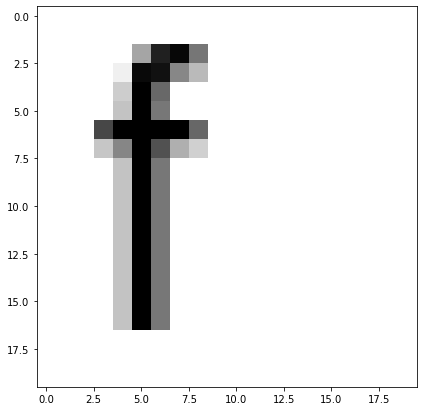

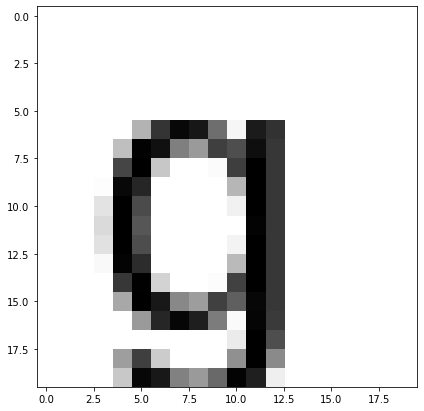

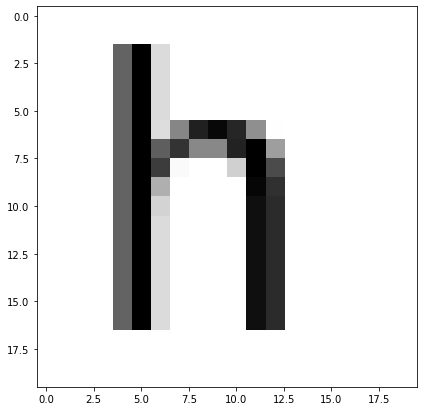

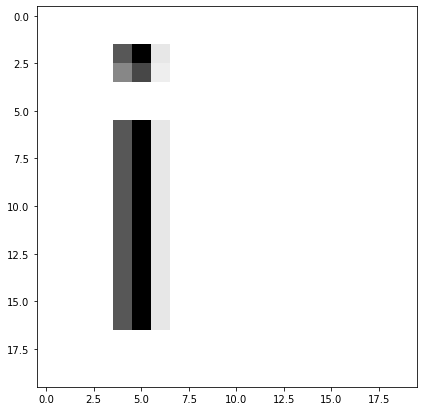

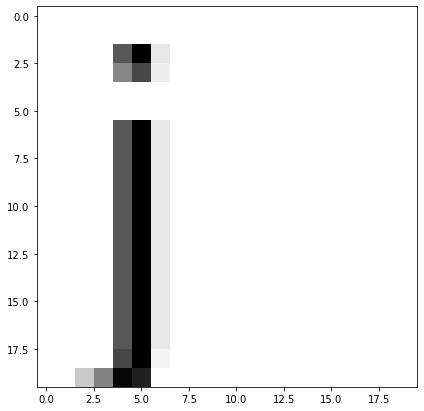

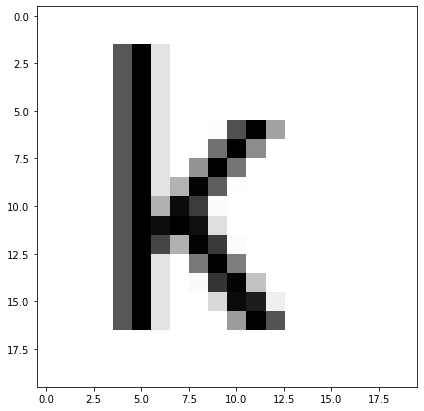

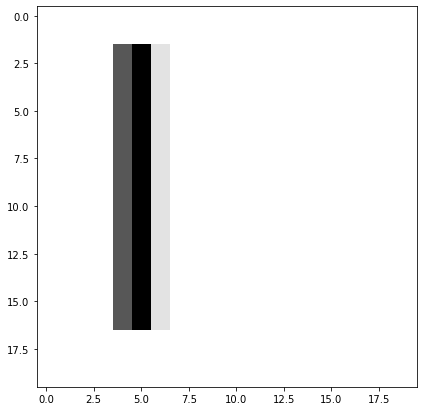

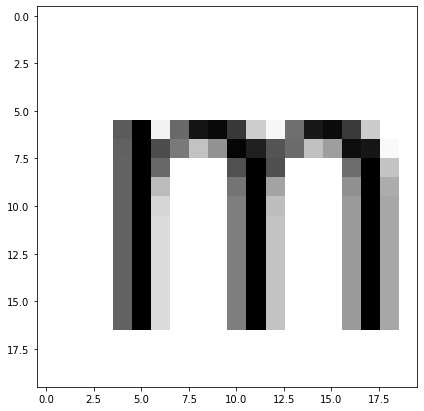

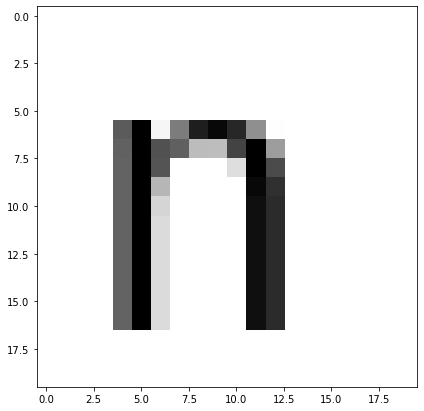

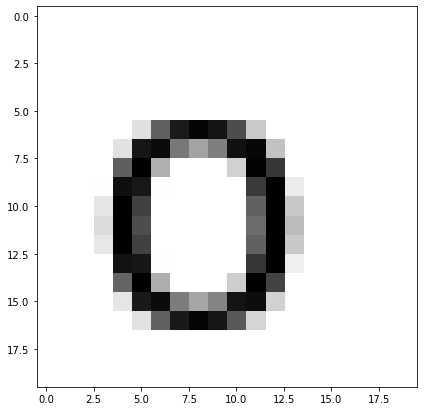

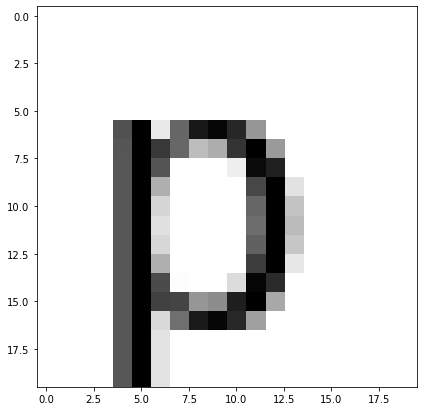

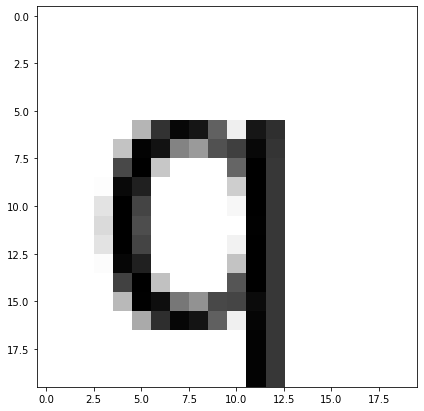

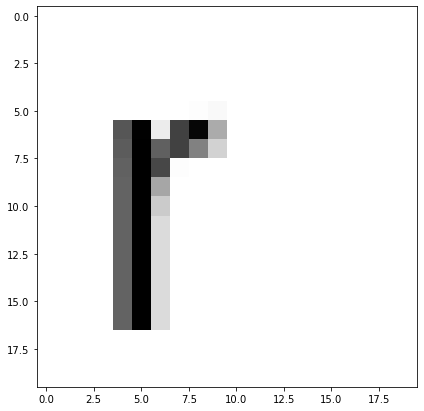

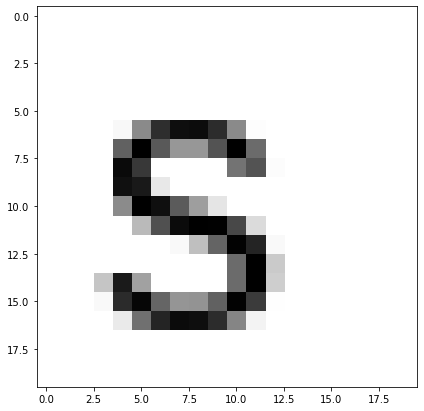

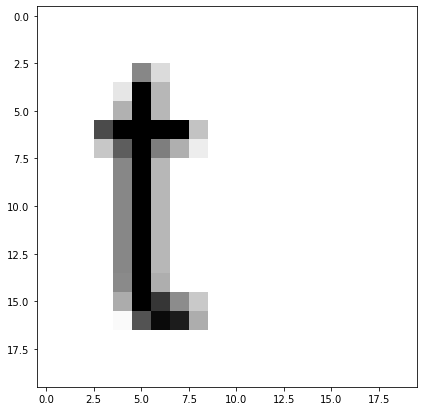

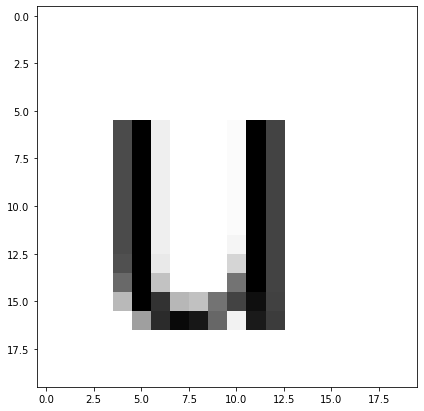

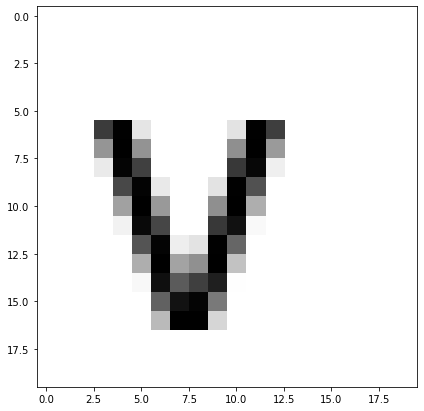

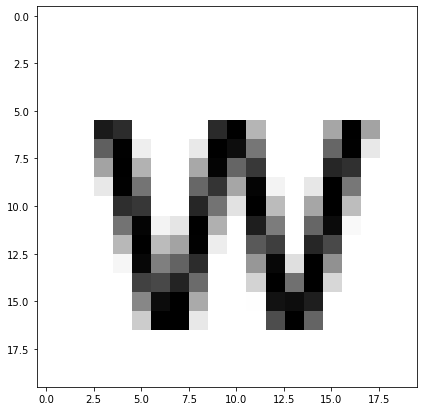

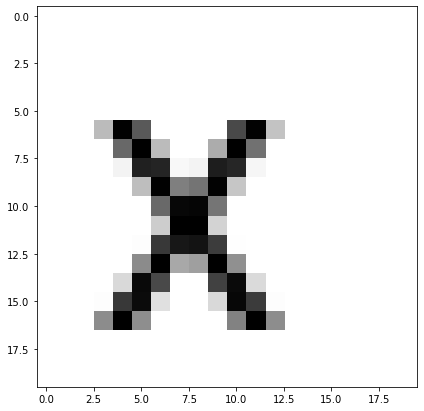

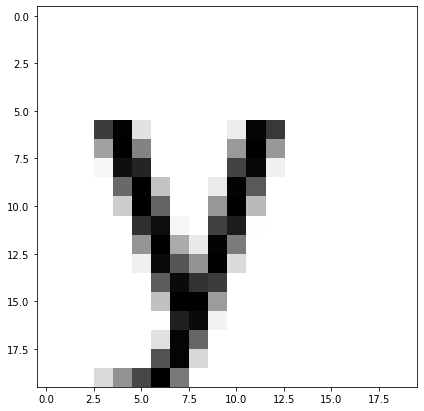

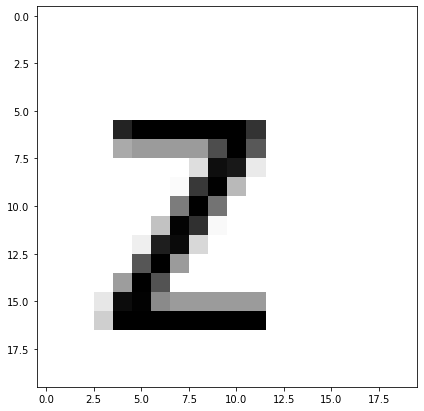

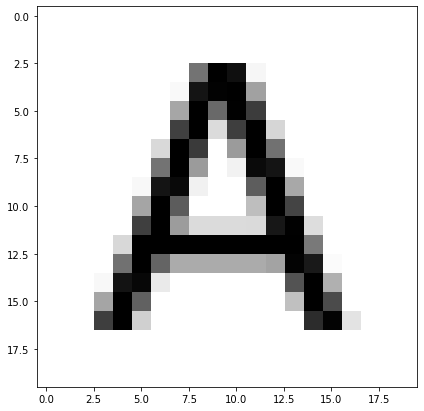

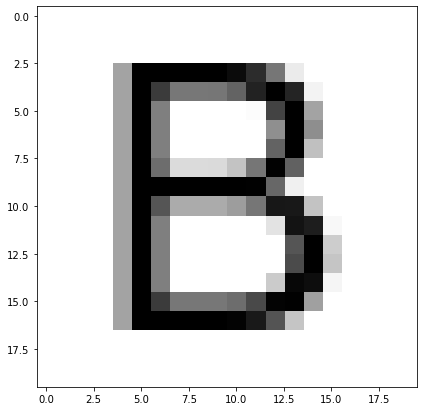

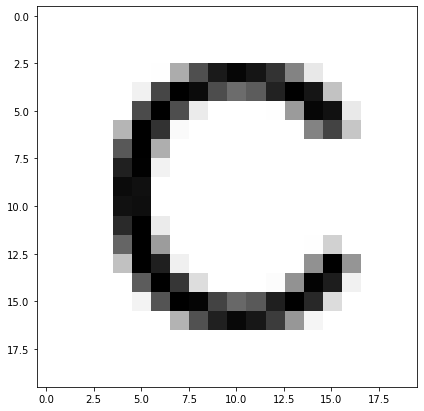

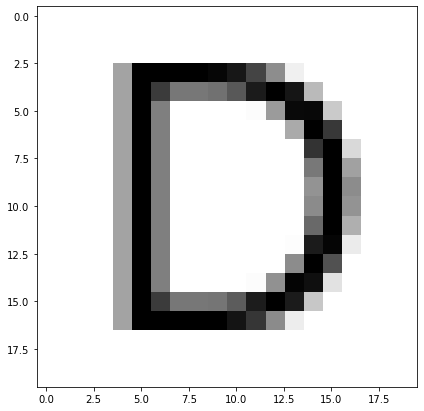

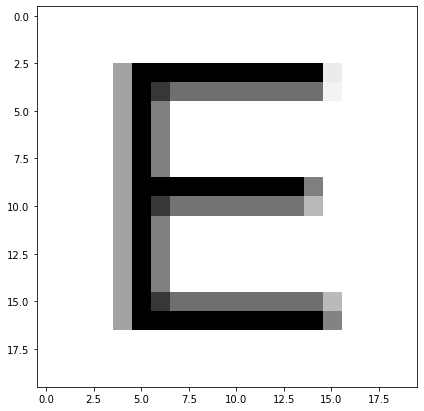

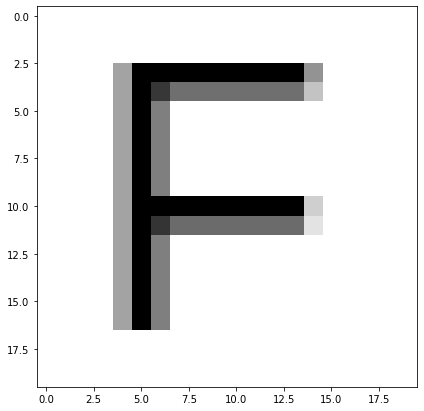

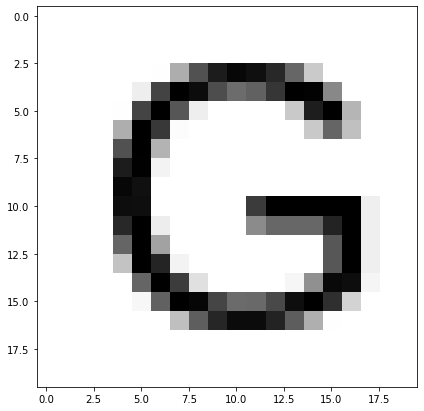

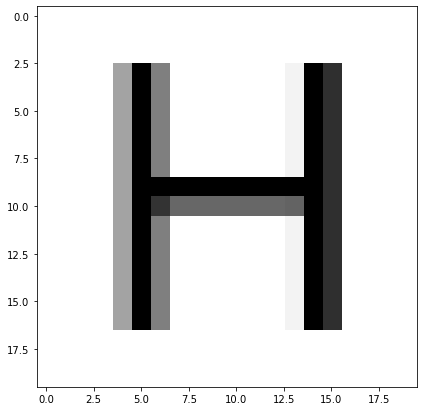

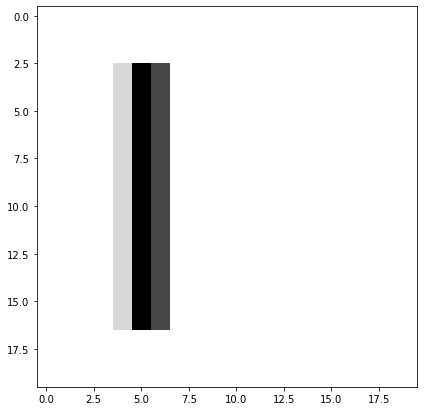

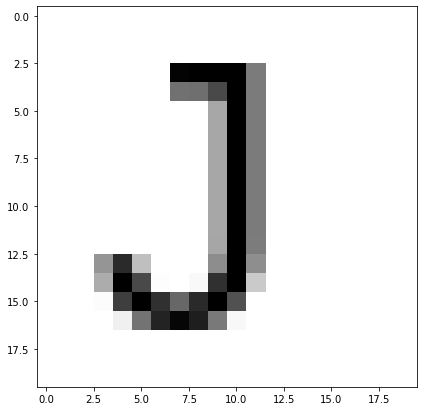

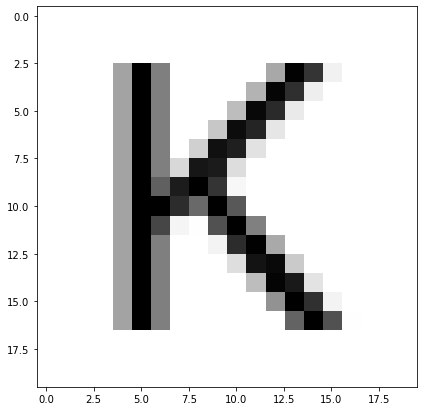

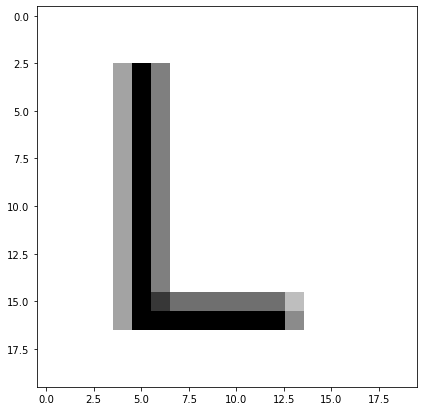

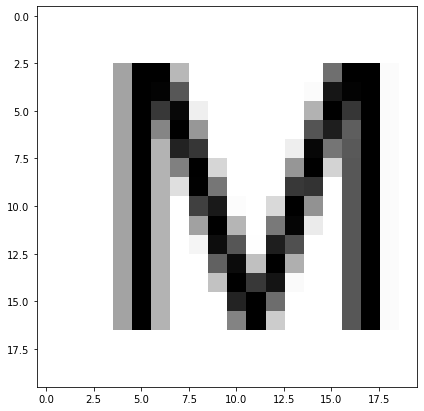

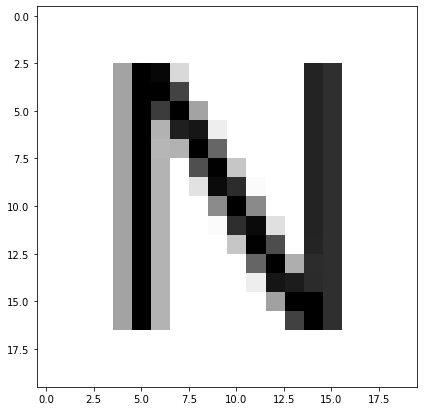

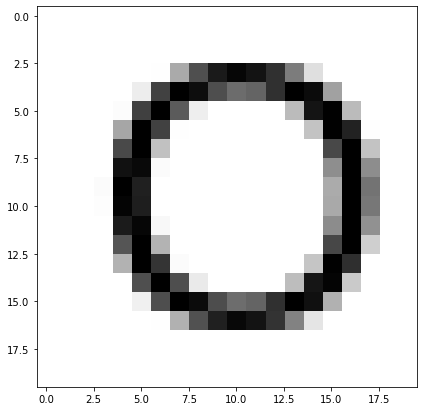

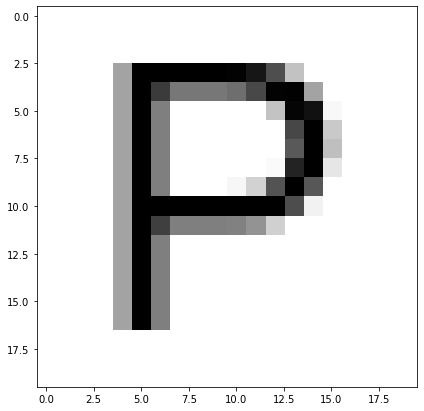

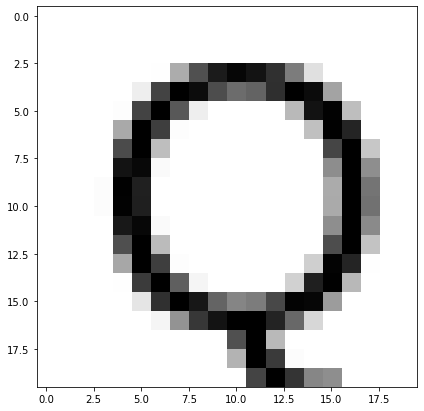

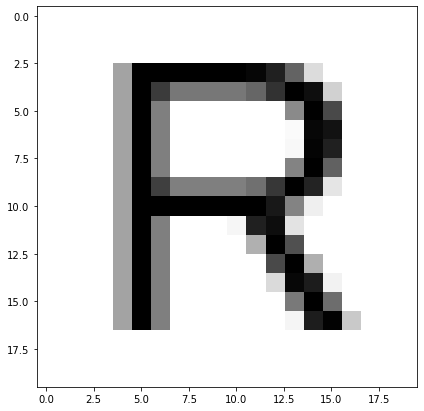

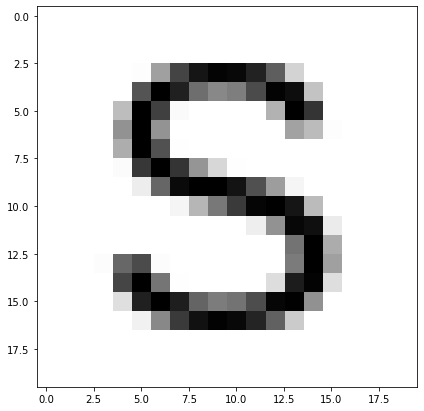

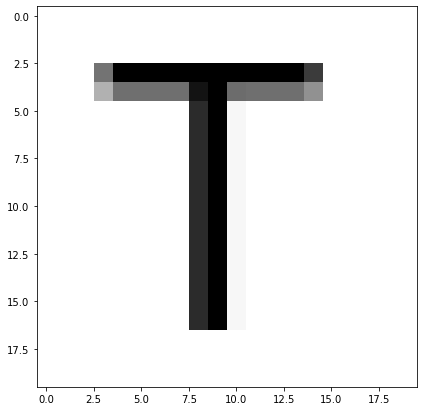

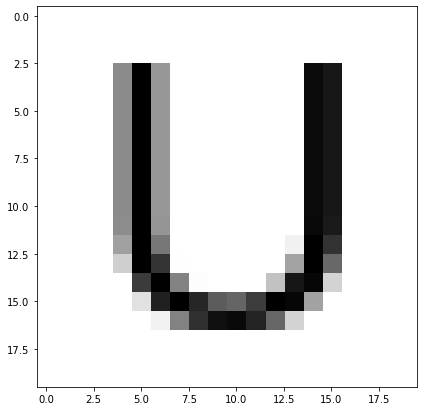

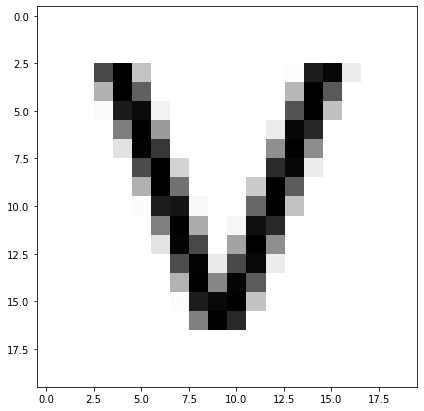

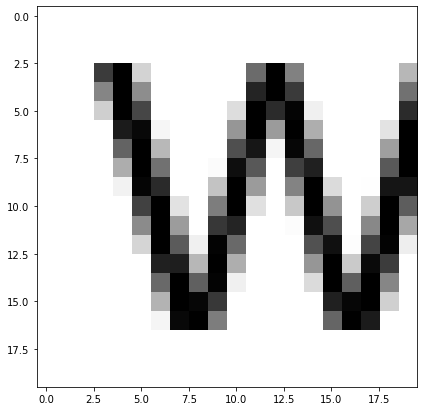

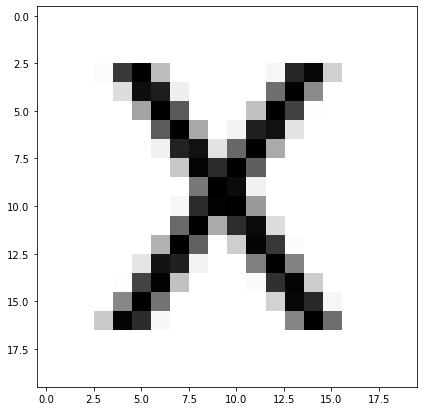

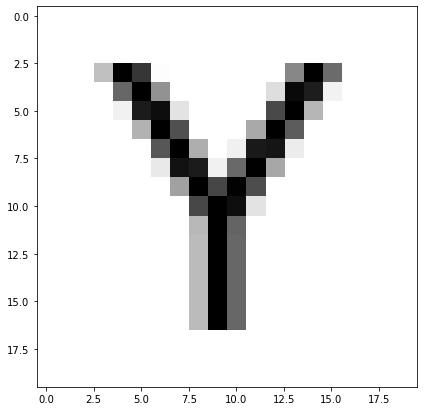

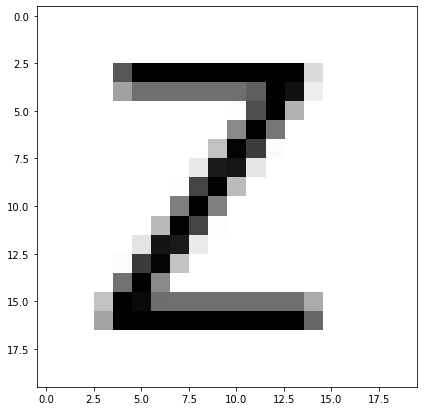

In [95]:
#for letter in string.ascii_letters:
#    plt.figure()
#    plt.imshow(render_letter(letter,20),cmap='gray')

In [96]:
n_letters = len(string.ascii_letters)

In [97]:
string.ascii_letters[:26]

'abcdefghijklmnopqrstuvwxyz'

In [98]:
probs_x = pyro.sample("probs_x", dist.Dirichlet(0.9 * torch.eye(26) + 0.1).to_event(1))

In [99]:
probs_x

tensor([[2.3883e-01, 2.4996e-14, 2.2233e-02, 3.8682e-02, 2.9775e-03, 7.5686e-03,
         2.3858e-10, 4.0911e-14, 2.4216e-05, 7.7656e-02, 1.8593e-07, 4.7826e-04,
         3.6909e-06, 9.4068e-08, 6.1606e-04, 1.1364e-10, 1.1449e-02, 1.3464e-06,
         2.0819e-06, 4.4148e-03, 3.4402e-01, 2.1419e-05, 2.1587e-03, 1.1027e-03,
         2.4777e-01, 3.0896e-08],
        [2.9710e-13, 1.8572e-01, 1.8073e-04, 3.1836e-01, 1.5899e-02, 3.7131e-08,
         2.3560e-01, 1.2110e-02, 1.7031e-01, 7.0778e-19, 1.0458e-08, 3.6856e-07,
         1.0293e-06, 1.3710e-05, 3.8226e-03, 5.1147e-06, 1.8751e-04, 6.3144e-03,
         7.5104e-03, 6.7070e-09, 5.1524e-07, 2.4060e-06, 1.9235e-11, 9.2107e-05,
         4.3864e-02, 2.5314e-11],
        [4.2082e-04, 2.4125e-07, 5.5135e-02, 2.2535e-12, 2.4533e-01, 2.3140e-01,
         5.2544e-06, 2.4168e-02, 1.6214e-07, 2.2215e-01, 2.1928e-07, 6.1266e-13,
         1.0347e-02, 2.7045e-08, 2.3077e-03, 1.1032e-14, 6.5876e-03, 1.0185e-03,
         1.3669e-08, 1.1801e-02, 1.4584e-

In [243]:
lettersize = 18
wordlength = 8

x = np.zeros((wordlength,),dtype=np.int)
img = np.zeros((lettersize*wordlength,lettersize))

for t in pyro.markov(range(wordlength)):
    x[t] = pyro.sample("x_{}".format(t), dist.Categorical(probs_x[x[t-1]]),infer={"enumerate": "parallel"})
    img[t*lettersize:(t+1)*lettersize,:] = render_letter(string.ascii_letters[x[t]],lettersize).T

In [244]:
img.shape

(144, 18)

In [245]:
rcParams['figure.figsize'] = 20,7

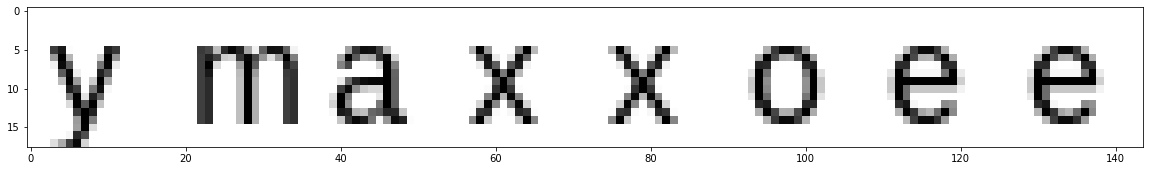

In [246]:
plt.imshow(img.T,cmap='gray')

In [305]:
def sample_point(w,h):
    x_prob = pyro.sample("x_prob", dist.Dirichlet(torch.ones(w)))
    y_prob = pyro.sample("y_prob", dist.Dirichlet(torch.ones(h)))
    x = pyro.sample("x", dist.Categorical(x_prob))
    y = pyro.sample("y", dist.Categorical(y_prob))
    return x,y

In [306]:
def sample_rectangle(w,h):
    x,y = sample_point(w,h)
    width,height = sample_point(w,h)
    color_intensity = pyro.sample("color_intensity",dist.Beta(0.5,0.5))
    return x,y,width,height,color_intensity

In [336]:
def sample_integer(minimum,maximum):
    n_prob = pyro.sample("n_prob", dist.Dirichlet(torch.ones(maximum-minimum)))
    n = pyro.sample("n", dist.Categorical(n_prob))
    return n+minimum

In [354]:
w,h = 400,500
img = np.ones((w,h))
x,y,width,height,color_intensity = sample_rectangle(w,h)
img[x:x+width,y:y+height] = color_intensity
x,y,width,height,color_intensity = sample_rectangle(w,h)
img[x:x+width,y:y+height] = color_intensity

In [371]:
lettersize = sample_integer(8,20)
wordlength = sample_integer(2,14)

word = np.zeros((wordlength,),dtype=np.int)
x_pos,y_pos = sample_point(w,h)
for t in pyro.markov(range(wordlength)):
    word[t] = pyro.sample("word_{}".format(t), dist.Categorical(probs_x[word[t-1]]),infer={"enumerate": "parallel"})
    tmp = render_letter(string.ascii_letters[word[t]],lettersize).T
    #print(tmp.shape)
    img[x_pos + t*lettersize:x_pos + (t+1)*lettersize,y_pos:y_pos + lettersize] = tmp

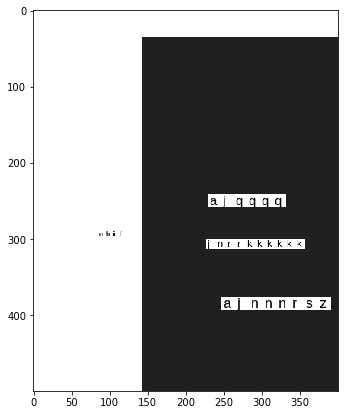

In [372]:
plt.imshow(img.T,cmap='gray',vmin=0,vmax=1)

In [373]:
x

tensor(143)

In [250]:
dist.Categorical(probs_x[x[t-1]]).sample()

IndexError: dimension specified as 0 but tensor has no dimensions

In [42]:
x[t]

0.2

In [34]:
dist.Categorical(probs_x[x[t-1]])

Categorical(probs: torch.Size([26]))

In [ ]:
for i in pyro.plate("sequences", len(sequences), batch_size):
    length = lengths[i]
    sequence = sequences[i, :length]
    x = 0
    for t in pyro.markov(range(length)):
        # On the next line, we'll overwrite the value of x with an updated
        # value. If we wanted to record all x values, we could instead
        # write x[t] = pyro.sample(...x[t-1]...).
        x = pyro.sample("x_{}_{}".format(i, t), dist.Categorical(probs_x[x]),
                        infer={"enumerate": "parallel"})